Architecture was taken from https://github.com/ozanciga/gans-with-pytorch <br>
UPD: corrected loss function as was mentioned <a href="https://www.kaggle.com/c/generative-dog-images/discussion/99485#latest-573753">here<a/>

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from tqdm import tqdm_notebook as tqdm
def seed_everything(seed = 224):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()   

In [2]:
np.random.uniform(0.7, 1.2)

0.9407175170447298

# Generator and Discriminator

In [3]:
class Generator(nn.Module):
    def __init__(self, nz=100, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )


    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.1, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        out = self.model(imgs)
        return out.view(-1, 1)

## Parameters of GAN

In [4]:
batch_size = 64
lr = 0.01
beta1 = 0.5
epochs = 300


fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loader and Augmentations

In [5]:
class DogDataset(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):
    
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs = []
        for img_name in self.img_names:
            img = Image.open(os.path.join(img_dir, img_name))
            
            if self.transform1 is not None:
                img = self.transform1(img)
                
            self.imgs.append(img)

    def __getitem__(self, index):
        img = self.imgs[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        
        return img

    def __len__(self):
        return len(self.imgs)

In [6]:
transform1 = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64)])

# Data augmentation and converting to tensors
random_transforms = [transforms.RandomRotation(degrees=5)]
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomApply(random_transforms, p=0.3), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                 
train_dataset = DogDataset(img_dir='../input/all-dogs/all-dogs/',
                           transform1=transform1,
                           transform2=transform2)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

                                           
imgs = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

### Let's see examples of traing data

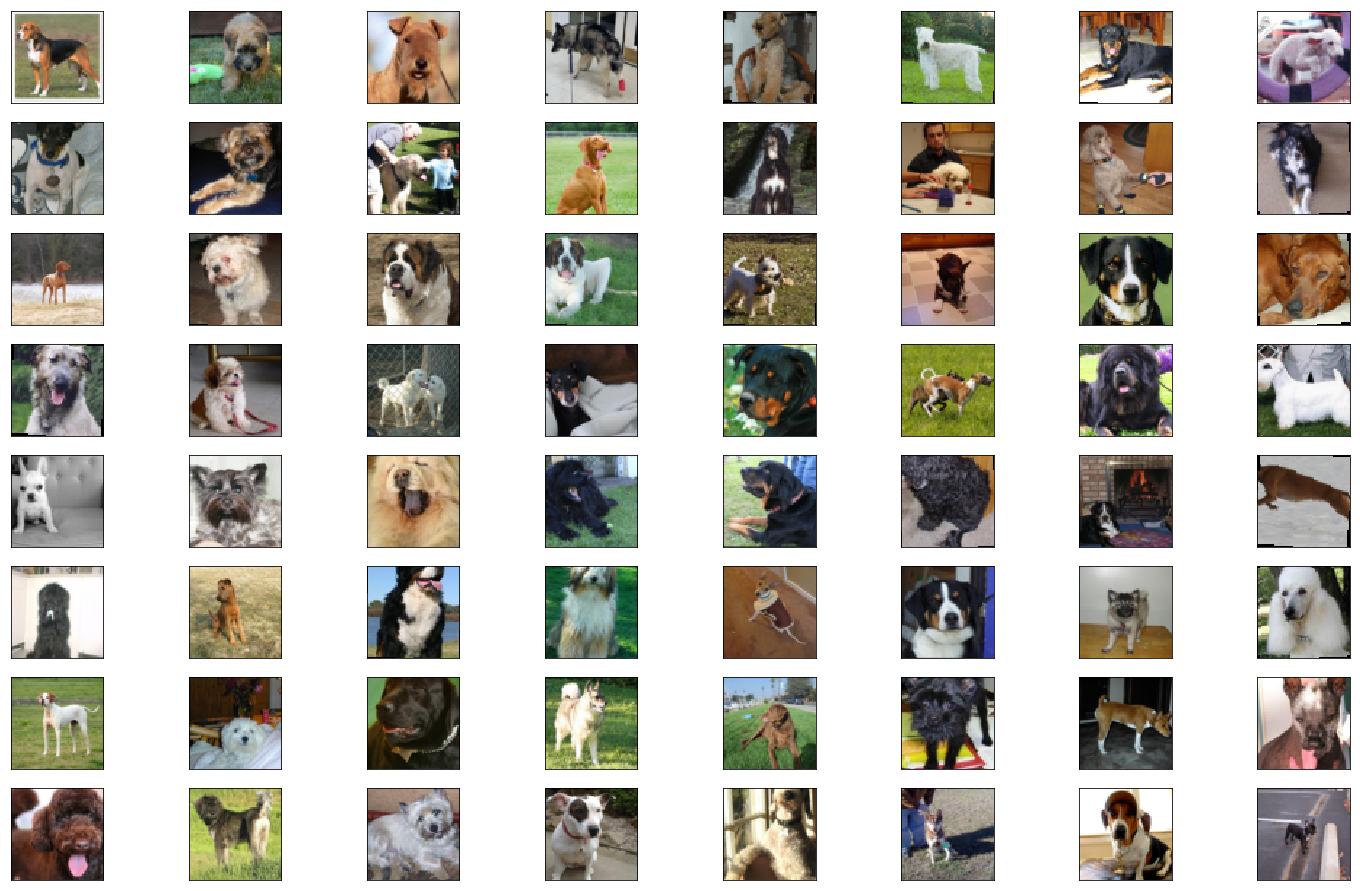

In [7]:
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(imgs):
    ax = fig.add_subplot(8, 8, ii + 1, xticks=[], yticks=[])
    
    plt.imshow((img+1)/2)

## Initialize models and optimizers

In [8]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0025, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

In [9]:
def show_generated_img():
    noise = torch.randn(1, nz, 1, 1, device=device)
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
    plt.imshow((gen_image+1)/2)
    plt.show()

## Training loop

[1/300][161/322] Loss_D: 0.7417 Loss_G: 8.5651
[1/300][322/322] Loss_D: 0.3482 Loss_G: 4.0228



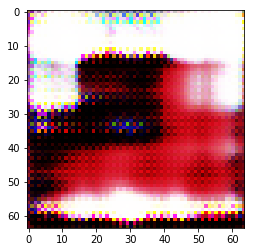

[2/300][161/322] Loss_D: 0.1271 Loss_G: 2.9595
[2/300][322/322] Loss_D: 0.1725 Loss_G: 2.7438



[3/300][161/322] Loss_D: 1.2855 Loss_G: 1.5684
[3/300][322/322] Loss_D: 0.2240 Loss_G: 3.5769



[4/300][161/322] Loss_D: 0.2567 Loss_G: 2.3799
[4/300][322/322] Loss_D: 0.3051 Loss_G: 3.2517



[5/300][161/322] Loss_D: 0.4960 Loss_G: 3.9166
[5/300][322/322] Loss_D: 0.1963 Loss_G: 3.3662



[6/300][161/322] Loss_D: 0.4631 Loss_G: 3.0806
[6/300][322/322] Loss_D: 0.1648 Loss_G: 5.7675



[7/300][161/322] Loss_D: 0.3045 Loss_G: 3.7123
[7/300][322/322] Loss_D: 0.2774 Loss_G: 6.4226



[8/300][161/322] Loss_D: 0.4972 Loss_G: 5.4045
[8/300][322/322] Loss_D: 0.2609 Loss_G: 4.8071



[9/300][161/322] Loss_D: 0.3780 Loss_G: 5.8475
[9/300][322/322] Loss_D: 0.6781 Loss_G: 2.7785



[10/300][161/322] Loss_D: 0.2297 Loss_G: 4.8061
[10/300][322/322] Loss_D: 0.3115 Loss_G: 3.6414



[11/300][161/322] Loss_D: 0.2813 Loss_G: 3.5865
[11/300][322/322] Loss_D: 0.9715 Loss_G: 3.5946



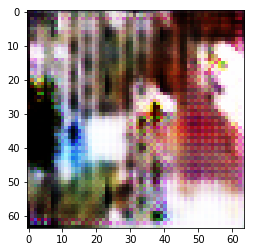

[12/300][161/322] Loss_D: 0.2970 Loss_G: 2.7665
[12/300][322/322] Loss_D: 0.6624 Loss_G: 2.3378



[13/300][161/322] Loss_D: 1.0284 Loss_G: 4.2712
[13/300][322/322] Loss_D: 0.3284 Loss_G: 2.5642



[14/300][161/322] Loss_D: 0.6897 Loss_G: 3.9827
[14/300][322/322] Loss_D: 1.0147 Loss_G: 3.3353



[15/300][161/322] Loss_D: 0.7052 Loss_G: 2.8977
[15/300][322/322] Loss_D: 0.4828 Loss_G: 4.5917



[16/300][161/322] Loss_D: 0.4771 Loss_G: 1.9691
[16/300][322/322] Loss_D: 1.1001 Loss_G: 4.5815



[17/300][161/322] Loss_D: 0.8190 Loss_G: 3.1819
[17/300][322/322] Loss_D: 0.2973 Loss_G: 2.8448



[18/300][161/322] Loss_D: 0.5893 Loss_G: 6.0321
[18/300][322/322] Loss_D: 0.7648 Loss_G: 1.9270



[19/300][161/322] Loss_D: 0.3234 Loss_G: 3.1241
[19/300][322/322] Loss_D: 0.9813 Loss_G: 4.5431



[20/300][161/322] Loss_D: 1.1251 Loss_G: 3.1413
[20/300][322/322] Loss_D: 0.7801 Loss_G: 8.7809



[21/300][161/322] Loss_D: 0.8345 Loss_G: 3.8776
[21/300][322/322] Loss_D: 0.4162 Loss_G: 3.5702



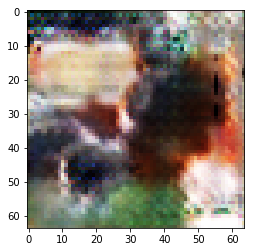

[22/300][161/322] Loss_D: 0.2530 Loss_G: 3.3579
[22/300][322/322] Loss_D: 0.2303 Loss_G: 4.1615



[23/300][161/322] Loss_D: 0.9734 Loss_G: 4.1751
[23/300][322/322] Loss_D: 1.0541 Loss_G: 4.2109



[24/300][161/322] Loss_D: 0.3956 Loss_G: 1.2004
[24/300][322/322] Loss_D: 0.4272 Loss_G: 2.6665



[25/300][161/322] Loss_D: 0.3399 Loss_G: 4.1614
[25/300][322/322] Loss_D: 0.4996 Loss_G: 3.1742



[26/300][161/322] Loss_D: 2.4770 Loss_G: 4.1066
[26/300][322/322] Loss_D: 0.9906 Loss_G: 8.6862



[27/300][161/322] Loss_D: 0.3608 Loss_G: 2.3124
[27/300][322/322] Loss_D: 0.7966 Loss_G: 3.2264



[28/300][161/322] Loss_D: 0.9542 Loss_G: 4.1922
[28/300][322/322] Loss_D: 0.6753 Loss_G: 4.9038



[29/300][161/322] Loss_D: 0.1951 Loss_G: 2.9159
[29/300][322/322] Loss_D: 0.4268 Loss_G: 3.2843



[30/300][161/322] Loss_D: 0.2602 Loss_G: 2.4592
[30/300][322/322] Loss_D: 0.4409 Loss_G: 4.9933



[31/300][161/322] Loss_D: 0.5587 Loss_G: 2.7034
[31/300][322/322] Loss_D: 0.4898 Loss_G: 5.3040



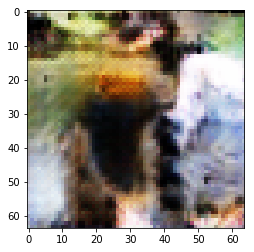

[32/300][161/322] Loss_D: 0.5986 Loss_G: 5.5828
[32/300][322/322] Loss_D: 0.9556 Loss_G: 5.8131



[33/300][161/322] Loss_D: 0.2051 Loss_G: 2.6195
[33/300][322/322] Loss_D: 0.6931 Loss_G: 5.6400



[34/300][161/322] Loss_D: 0.8250 Loss_G: 4.4018
[34/300][322/322] Loss_D: 0.1607 Loss_G: 3.8121



[35/300][161/322] Loss_D: 0.2088 Loss_G: 4.5164
[35/300][322/322] Loss_D: 0.1831 Loss_G: 4.2870



[36/300][161/322] Loss_D: 0.2475 Loss_G: 2.3761
[36/300][322/322] Loss_D: 0.5251 Loss_G: 6.7393



[37/300][161/322] Loss_D: 0.3826 Loss_G: 4.9839
[37/300][322/322] Loss_D: 0.6627 Loss_G: 4.9800



[38/300][161/322] Loss_D: 0.2586 Loss_G: 2.3244
[38/300][322/322] Loss_D: 0.1603 Loss_G: 4.7126



[39/300][161/322] Loss_D: 0.2377 Loss_G: 4.2550
[39/300][322/322] Loss_D: 0.2724 Loss_G: 4.3224



[40/300][161/322] Loss_D: 0.5024 Loss_G: 4.9439
[40/300][322/322] Loss_D: 0.8635 Loss_G: 1.4519



In [10]:
for epoch in range(epochs):
    
    for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        real_label = np.random.uniform(0.7, 1.2)
        labels = torch.full((batch_size, 1), real_label, device=device)
        outputR = netD(real_images)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        outputF = netD(fake.detach())
        errD = (torch.mean((outputR - torch.mean(outputF) - labels) ** 2) + 
                torch.mean((outputF - torch.mean(outputR) + labels) ** 2))/2
        errD.backward(retain_graph=True)
        optimizerD.step()
        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        outputF = netD(fake)   
        errG = (torch.mean((outputR - torch.mean(outputF) + labels) ** 2) +
                torch.mean((outputF - torch.mean(outputR) - labels) ** 2))/2
        errG.backward()
        optimizerG.step()
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item()))
    if epoch%10 == 0:
        show_generated_img()

## Let's visualise generated results 

In [11]:
gen_z = torch.randn(64, nz, 1, 1, device=device)
gen_images = (netG(gen_z).to("cpu").clone().detach() + 1)/2
gen_images = gen_images.numpy().transpose(0, 2, 3, 1)

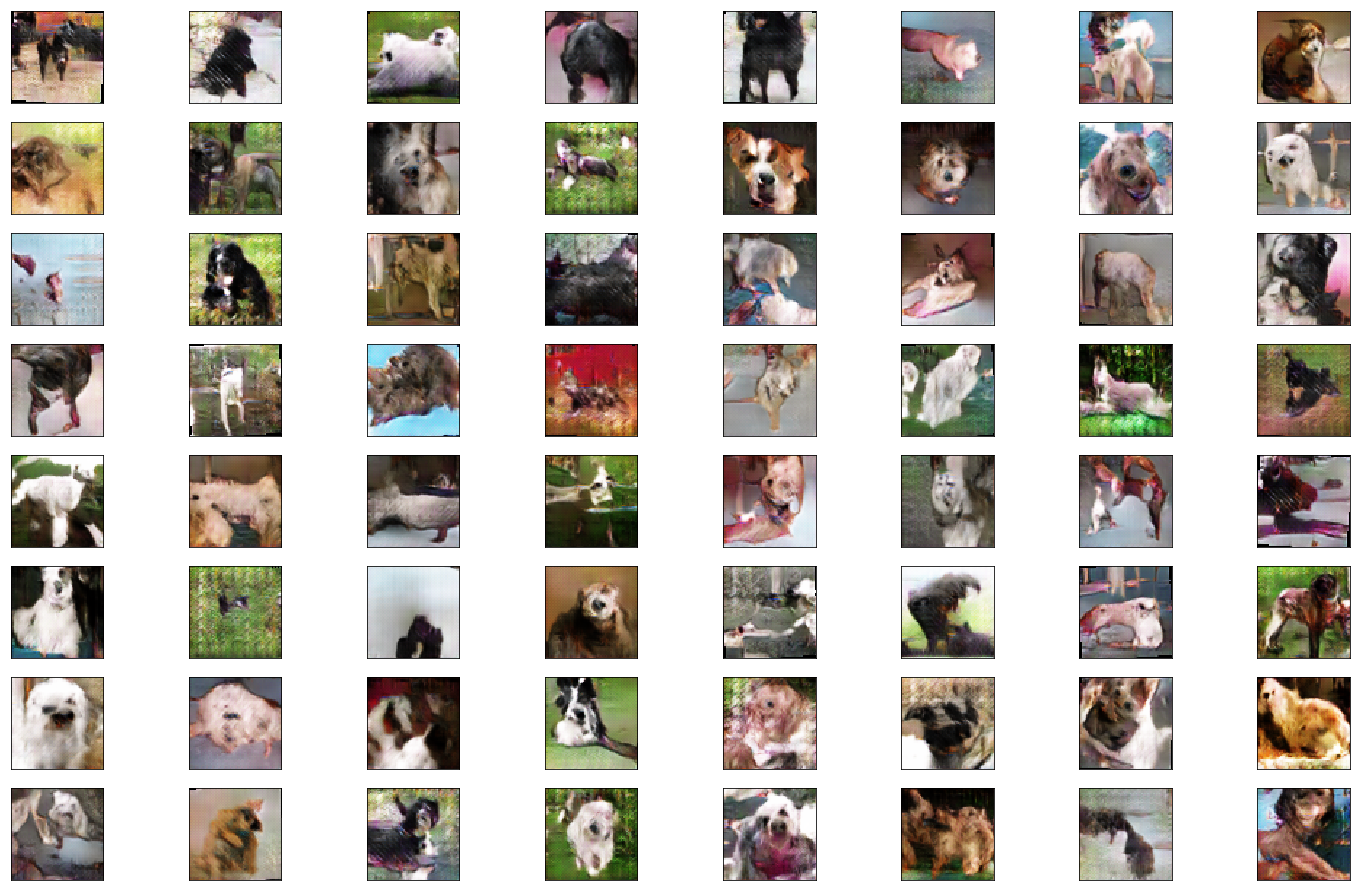

In [12]:
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(gen_images):
    ax = fig.add_subplot(8, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow(img)

## Make predictions and submit

In [13]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = (netG(gen_z) + 1)/2
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'